## Collaborative Filtering for Amazon Products

**Based on:** [Collaborative Filtering for Movie Recommendations](https://keras.io/examples/structured_data/collaborative_filtering_movielens/) by [Siddhartha Banerjee](https://twitter.com/sidd2006)<br>
**Author:** Nathan Pannell<br>
**Date created:** 2025/02/27<br>
**Description:** Recommending Amazon products with category agnositic collaborative filtering.<br>
**Dataset:** *Amazon Reviews 2023* from [McAuley Lab](https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras import layers
from keras import ops

import datasets
datasets.logging.set_verbosity_error()

### Category Selection

The Amazon Reviews 2023 dataset contains product reviews across many different categories.<br>
To make the dataset more manageable in size, only a single category is considered at a time.<br>

The selected category's dataset is loaded from Hugging Face.<br>
**NOTE:** This is not the raw dataset, it is preprocessed to model a 5-degenerate graph (each item has at least 5 interactions)<br>

Resources:
- [Graph Degeneracy](https://en.wikipedia.org/wiki/Degeneracy_(graph_theory))
- [Preprocessed Dataset](https://amazon-reviews-2023.github.io/data_processing/5core.html)


In [2]:
AVAILABLE_CATEGORIES = [
    'All_Beauty', 'Arts_Crafts_and_Sewing', 'Automotive', 
    'Baby_Products', 'Beauty_and_Personal_Care', 'Books', 
    'CDs_and_Vinyl', 'Cell_Phones_and_Accessories', 'Clothing_Shoes_and_Jewelry', 
    'Electronics', 'Gift_Cards', 'Grocery_and_Gourmet_Food', 'Health_and_Household', 
    'Home_and_Kitchen', 'Industrial_and_Scientific', 'Kindle_Store', 
    'Magazine_Subscriptions', 'Movies_and_TV', 'Musical_Instruments', 
    'Office_Products', 'Patio_Lawn_and_Garden', 'Pet_Supplies', 
    'Software', 'Sports_and_Outdoors', 'Tools_and_Home_Improvement', 
    'Toys_and_Games', 'Unknown', 'Video_Games'
]

SELECTED_CATEGORY = 'Magazine_Subscriptions'

dataset = datasets.load_dataset("McAuley-Lab/Amazon-Reviews-2023", "5core_rating_only_" + SELECTED_CATEGORY, trust_remote_code=True)
df = dataset['full'].to_pandas()

### Data preprocessing

A few steps are needed before creating the matrix factorization embedding
- Map user_ids (Ex. `AEVPPTMG43C6GWSR7I2UGRQN7WFQ`) to integers
- Map product_ids, referred to as parent_asin, (Ex. `B09WMQ6DXG`) to integers
- Normalize ratings to `[0, 1]`
- Use a 90/10 train/validation split

In [3]:
user_ids = df['user_id'].unique().tolist()
encode_user = {x: i for i, x in enumerate(user_ids)}
decode_user = {i: x for i, x in enumerate(user_ids)}

product_ids = df['parent_asin'].unique().tolist()
encode_product = {x: i for i, x in enumerate(product_ids)}
decode_product = {i: x for i, x in enumerate(product_ids)}

df["user"] = df["user_id"].map(encode_user)
df["product"] = df["parent_asin"].map(encode_product)

df["rating"] = df["rating"].values.astype(np.float32)


# Statistical summary of data
min_rating = min(df["rating"])
max_rating = max(df["rating"])
num_users = len(user_ids)
num_products = len(product_ids)
num_reviews = len(df)

print(f'Users       : {num_users:9,d}')
print(f'Products    : {num_products:9,d}')
print(f'Reviews     : {num_reviews:9,d}')
print(f'Rating range: {min_rating} - {max_rating}')
print()
print(f'{num_reviews/num_users:f} reviews per user')
print(f'{num_reviews/num_products:f} reviews per product')

Users       :        30
Products    :        21
Reviews     :       176
Rating range: 1.0 - 5.0

5.866667 reviews per user
8.380952 reviews per product


In [4]:
df = df.sample(frac=1, random_state=0)
x = df[["user", "product"]].values
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

print(f'{x_train.shape=} {y_train.shape=}')
print(f'{x_val.shape=} {y_val.shape=}')

x_train.shape=(158, 2) y_train.shape=(158,)
x_val.shape=(18, 2) y_val.shape=(18,)


### Create the model

Uses 50-dimensional embedding vectors for both users and products.

Uses a dot product of the embedding vectors, in addition to a product-bias and user-bias.

Predicted score is scaled to `[0, 1]` via sigmoid.

In [5]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_products, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_products = num_products
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.product_embedding = layers.Embedding(
            num_products,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.product_bias = layers.Embedding(num_products, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        product_vector = self.product_embedding(inputs[:, 1])
        product_bias = self.product_bias(inputs[:, 1])

        dot_user_product = ops.tensordot(user_vector, product_vector, 2)
        a = dot_user_product + user_bias + product_bias
        
        return ops.nn.sigmoid(a)


model = RecommenderNet(num_users, num_products, EMBEDDING_SIZE)
model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
)

### Train the model and plot training loss

In [6]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - loss: 3.1557 - val_loss: 0.5786
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 2.9960 - val_loss: 0.5809
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.3297 - val_loss: 0.5830
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.7660 - val_loss: 0.5851
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.8822 - val_loss: 0.5868


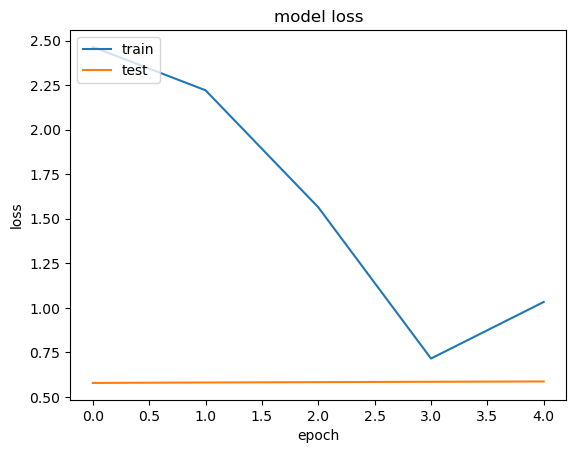

In [7]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

### Evaluate model accuracy by recommending items

We start by importing item metadata and selecting a random user. This metadata includes titles and subcategories for each product.

By checking which items have an embedding but haven't been rated by the user, we can make predictions about what they might rate each unseen item.

Finally, by presenting the 10 elements with the highest predicted rating, we can recommend products the user may like. :)

#### Extensions to this recommendation strategy

- Use probabilistic selection. By sampling based on predicted ratings, with higher matches more likely to be recommended, the RS can decrease the strong bias for selecting the highest rated items.
- Add a 'average product rating' penalty. This can increase the diversity of recommendations by selecting less popular, but potentially more relevant products for a user based on their niche.

In [8]:
meta = datasets.load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_" + SELECTED_CATEGORY, split="full", trust_remote_code=True)
meta_df = meta.to_pandas()

user_id = df.user_id.sample(1).iloc[0]
user_activity = df[df.user_id == user_id] # list of reviews by user
unseen_products = meta_df[~meta_df['parent_asin'].isin(user_activity.parent_asin.values)]['parent_asin']
unseen_products = list(set(unseen_products).intersection(set(encode_product.keys()))) # discard products we don't have an embedding for
unseen_products = [[encode_product.get(x)] for x in unseen_products]
user_index = encode_user.get(user_id)

user_product_array = np.hstack(
    ([[user_index]] * len(unseen_products), unseen_products)
)
ratings = model.predict(user_product_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_product_ids = [decode_product.get(unseen_products[x][0]) for x in top_ratings_indices]

print("Products with high ratings from user")
print("-" * 32)
top_products_user = (
    user_activity.sort_values(by="rating", ascending=False)
    .head(5)
    .parent_asin.values
)
meta_df_rows = meta_df[meta_df["parent_asin"].isin(top_products_user)]
for row in meta_df_rows.itertuples():
    print(row.title)

print("-" * 32)
print("Top 10 product recommendations")
print("-" * 32)
recommended_products = meta_df[meta_df["parent_asin"].isin(recommended_product_ids)]
for row in recommended_products.itertuples():
    print(row.title)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Products with high ratings from user
--------------------------------
Martha Stewart Living    Print Magazine
Taste of Home    Print Magazine
Good Housekeeping    Print Magazine
Family Handyman    Print Magazine
Southern Living    Print Magazine
--------------------------------
Top 10 product recommendations
--------------------------------
Women's Health    Print Magazine
Popular Mechanics    Print Magazine
HGTV Magazine    Print Magazine
O, The Oprah Magazine    Print Magazine
House Beautiful    Print Magazine
Reader's Digest    Print Magazine
Food Network Magazine    Print Magazine
Woman's Day    Print Magazine
Do it Yourself    Print Magazine
Popular Science    Print Magazine
